## 허깅페이스 프로젝트 직접 만들기

목표: Huggingface의 model(klue/ber-base)를 활용해 네이버 무비 감성 분석 태스크를 수행

[Model](https://huggingface.co/klue/bert-base) / [Data](https://github.com/e9t/nsmc)

Result: No Bucket.  
데이터 크기, 12500 / 2500 / 5000 (Train / Val / Test)

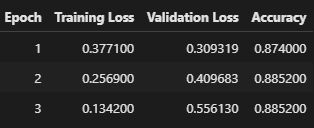

```
{'eval_loss': 0.775333821773529,
 'eval_accuracy': 0.848,
 'eval_runtime': 13.9492,
 'eval_samples_per_second': 35.844,
 'eval_steps_per_second': 4.516,
 'epoch': 3.0}
 ```

이슈: Colab은 GPU 사용량이 부족하고, Kaggle 노트북은 Wandb 문제로 실행이 안되고, 로컬과 아이펠 커널은 메모리 부족으로 데이터 셋을 위 이상으로 키우기 어려움

현재 VRAM 사용량: >7.5GB out of 8.0GB
___
Result: Bucketing 적용(동적 패딩)  
데이터 크기, 12500 / 2500 / 5000 (Train / Val / Test)

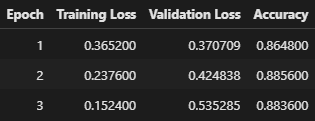

```
{'eval_loss': 0.7024808526039124,
 'eval_accuracy': 0.846,
 'eval_runtime': 6.8709,
 'eval_samples_per_second': 72.771,
 'eval_steps_per_second': 9.169,
 'epoch': 3.0}
 ```
 
 확실히 동적 패딩을 적용한 경우 작업 속도가 빠르다.

### 라이브러리 호출

In [6]:
import pandas as pd
from datasets import Dataset, load_dataset

from evaluate import load

import os
import numpy as np
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

### NSMC 데이터 가져오기

In [3]:
huggingface_nsmc_dataset = load_dataset('e9t/nsmc')
print(huggingface_nsmc_dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


### HuggingFace 데이터셋 구조(예시)

```python
DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})
```

In [4]:
train = huggingface_nsmc_dataset['train']
test_dataset = huggingface_nsmc_dataset['test']

In [7]:
#val_dataset = train.select(range(len(train) - 25000, len(train)))
#train_dataset = train.select(range(len(train) - 25000))

val_dataset = train.select(range(len(train) - 2500, len(train)))
train_dataset = train.select(range(12500))
test_dataset = test_dataset.select(range(500))

In [8]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 12500
})
Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 2500
})
Dataset({
    features: ['id', 'document', 'label'],
    num_rows: 500
})


### klue/bert-base 모델 불러오기

In [ ]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

huggingface_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 2)

### HuggingFace Tokenizer로 토큰화하기

In [10]:
def transform(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,
        )

In [11]:
hf_train = train_dataset.map(transform, batched=True)
hf_val = val_dataset.map(transform, batched=True)
hf_test = test_dataset.map(transform, batched=True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

### Train/Evaluation

In [ ]:
output_dir = './transformers_temp'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

In [ ]:
metric = load('accuracy') # evaluate.load 사용

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train,    # training dataset
    eval_dataset=hf_val,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.377100,0.309319,0.874000
2,0.256900,0.409683,0.885200
3,0.134200,0.556130,0.885200


TrainOutput(global_step=4689, training_loss=0.2573159458439445, metrics={'train_runtime': 3896.2385, 'train_samples_per_second': 9.625, 'train_steps_per_second': 1.203, 'total_flos': 9866664576000000.0, 'train_loss': 0.2573159458439445, 'epoch': 3.0})

In [ ]:
trainer.evaluate(hf_test)

{'eval_loss': 0.775333821773529,
 'eval_accuracy': 0.848,
 'eval_runtime': 13.9492,
 'eval_samples_per_second': 35.844,
 'eval_steps_per_second': 4.516,
 'epoch': 3.0}

### Bucketing 적용

In [12]:
output_dir = './transformers_temp'
training_arguments = TrainingArguments(
    output_dir,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    group_by_length=True,
)

# DataCollatorWithPadding 설정
data_collator = DataCollatorWithPadding(huggingface_tokenizer)

In [14]:
metric = load('accuracy') # evaluate.load 사용

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train,    # training dataset
    eval_dataset=hf_val,       # evaluation dataset
    compute_metrics=compute_metrics,
    data_collator=data_collator
)
trainer.train()

In [ ]:
trainer.evaluate(hf_test)